# Deep Learning Challenge (optional)

![](../../public/titanic_intro.png)

In the early 20th century, the RMS Titanic was the pinnacle of luxury and innovation, a marvel of modern engineering. It was hailed as the "unsinkable" ship, carrying over 2,200 passengers and crew on its maiden voyage across the Atlantic. However, in the icy waters of the North Atlantic, disaster struck, and the unthinkable happened—the Titanic collided with an iceberg and sank, leading to one of the most tragic maritime disasters in history.

Now, over a century later, you are tasked with an important mission: to delve into the historical data and build a predictive model that could have foretold the fate of the passengers aboard the Titanic. This dataset contains detailed records of the passengers, including information such as age, gender, ticket class, family size, and more. **Your goal is to develop a neural network model that accurately predicts whether a passenger would have survived or perished on that fateful night.**

Your predictive model won't just be a technical achievement; it will serve as a lens through which we can better understand the human factors and decisions that played a critical role in survival. As you work through this challenge, you’ll follow the standard deep learning workflow, applying your skills to each stage:

- Data Collection: The data you need has already been gathered from historical records.
- Data Preprocessing: Clean and prepare the data for analysis (partially done for you).
- Exploratory Data Analysis (EDA): Investigate the data and uncover key patterns (partially done for you).
- Feature Engineering: Create or modify features to enhance your model’s performance (paritally done for you).
- Model Architecture Design: Choose an appropriate structure for your neural network model.
- Training: Train your model using the provided dataset.
- Evaluation: Assess your model's accuracy using a validation set and other techniques.
- Hyperparameter Tuning: Fine-tune the model’s parameters to improve performance.
- Model Testing: Test your final model on a separate test set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# sibsp        # number of siblings / spouses aboard the Titanic 	
# parch        # number of parents / children aboard the Titanic 	
# ticket       # Ticket number 	
# fare         # Passenger fare
# cabin        # Cabin number
# embark_town  # Port of Embarkation 	

#sibsp: The dataset defines family relations in this way:
#Sibling = brother, sister, stepbrother, stepsister
#Spouse = husband, wife (mistresses and fiancés were ignored)

#parch: The dataset defines family relations in this way:
#Parent = mother, father
#Child = daughter, son, stepdaughter, stepson
#Some children travelled only with a nanny, therefore parch=0 for them.

# load titanic dataset (DO NOT MODIFY)
df = sns.load_dataset("titanic")

## Exploratory Data Analysis
Provided below is some starter code to help familiarize yourself with the Titanic dataset. Further data analysis is encouraged but not required.

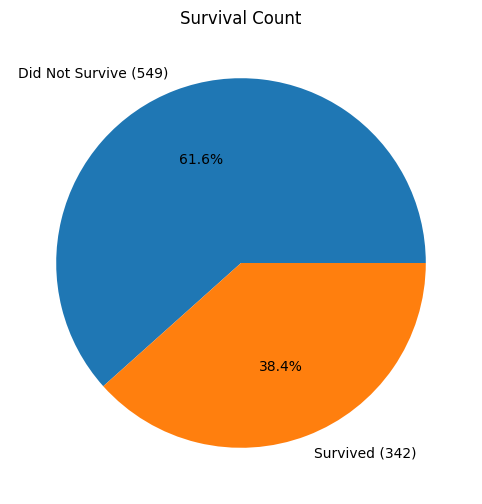

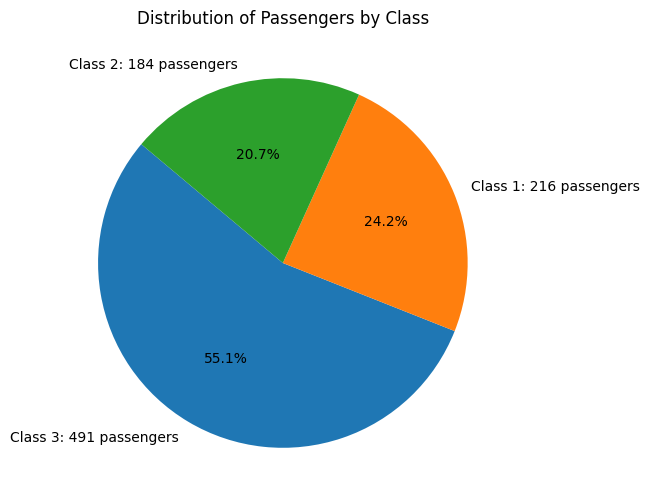

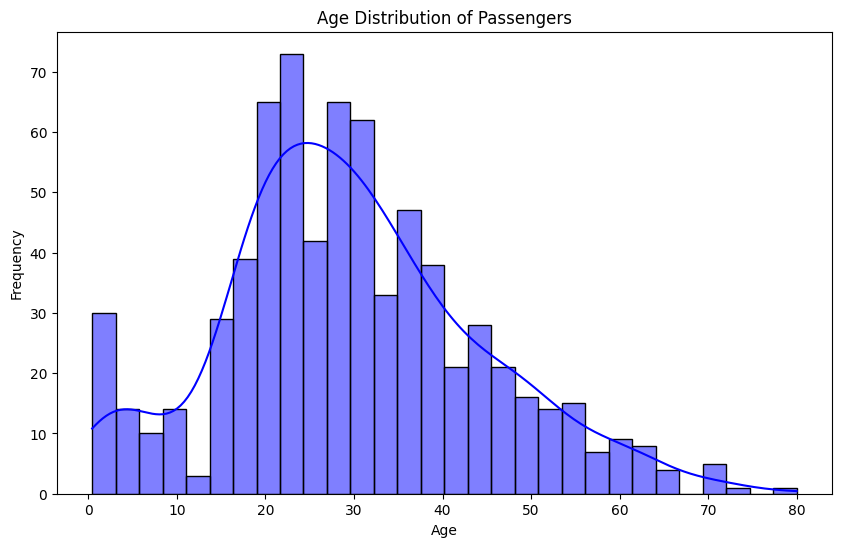

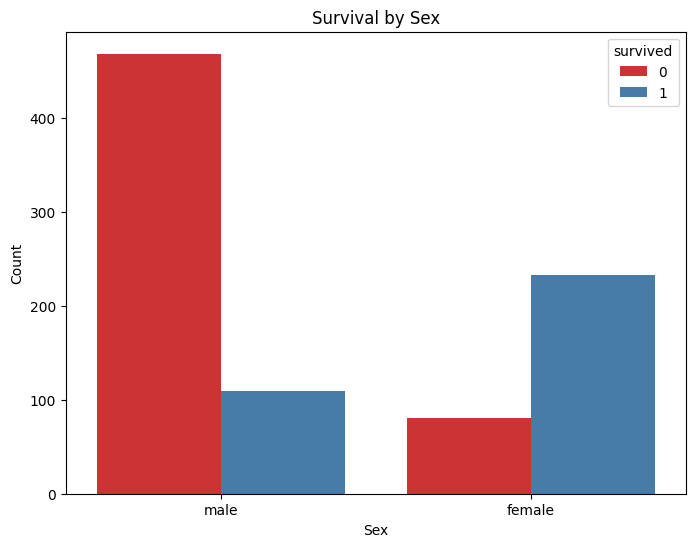

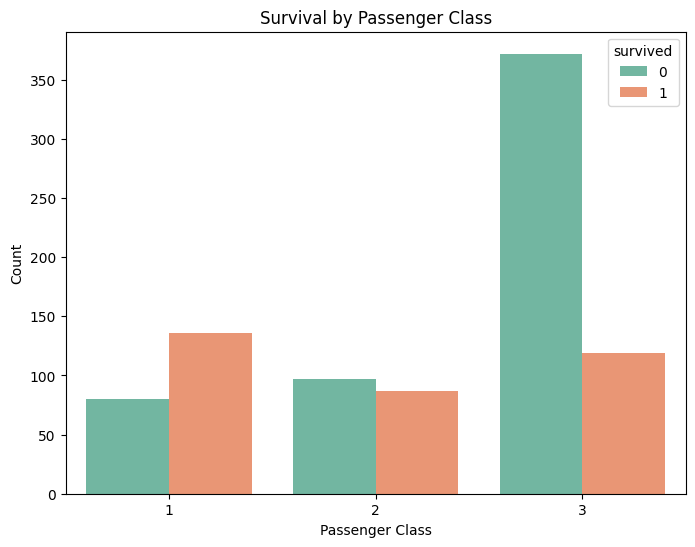

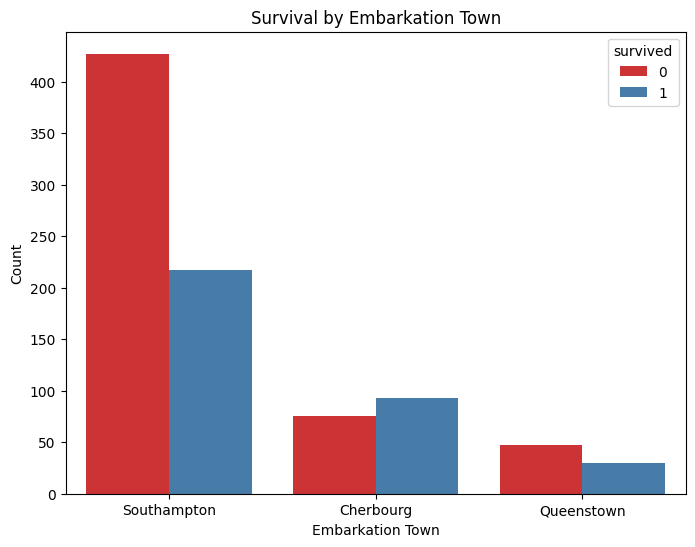

In [3]:
df.head()

##############################
# Uncomment code to see output
##############################

df.shape
df.isna().sum()
df.describe()

## Pie Chart for Survived
plt.figure(figsize=(8, 6))
plt.pie(df["survived"].value_counts(), labels=[f"Did Not Survive ({df.shape[0]-df['survived'].sum()})", f"Survived ({df['survived'].sum()})"], autopct='%1.1f%%')
plt.title('Survival Count')
plt.show()

## Pie Chart for Pclass
pclass_counts = df['pclass'].value_counts()
labels = [f'Class {cls}: {count} passengers' for cls, count in zip(pclass_counts.index, pclass_counts.values)]
plt.figure(figsize=(8, 6))
plt.pie(pclass_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Passengers by Class')
plt.show()

## Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['age'].dropna(), kde=True, bins=30, color='blue')
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Survival by Sex
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', hue='survived', data=df, palette='Set1')
plt.title('Survival by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

## Survival by Passenger Class
plt.figure(figsize=(8, 6))
sns.countplot(x='pclass', hue='survived', data=df, palette='Set2')
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()

## Survival by Embark Town
plt.figure(figsize=(8, 6))
sns.countplot(x='embark_town', hue='survived', data=df, palette='Set1')
plt.title('Survival by Embarkation Town')
plt.xlabel('Embarkation Town')
plt.ylabel('Count')
plt.show()

## Data Preprocessing and Feature Engineering

In [4]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [5]:
# drop columns that are redundant or contain many NaN values
df = df.drop(["pclass", "alive", "embarked", "alone", "adult_male", "deck", "age"], axis = 1)
df = df.dropna(subset=["embark_town"])

# TODO: Further data preprocessing (optional)
#Having Family size feature
df['family_size'] = df['sibsp'] + df['parch'] + 1

# Create is_alone feature (binary)
df['is_alone'] = (df['family_size'] == 1).astype(int)

# Bin fare into categories for better feature representation
df['fare_binned'] = pd.cut(df['fare'], bins=4, labels=['low', 'medium', 'high', 'very_high'])
df = df.join(pd.get_dummies(df['fare_binned'], prefix='fare'))
df = df.drop(['fare_binned'], axis=1)

In [6]:
# One Hot Encode categorical variables
df["sex"] = df["sex"].map({"male": 0, "female": 1})
for label in ["class", "who", "embark_town"]:
    df = df.join(pd.get_dummies(df[label], prefix=label))
    df = df.drop(label, axis=1)

# TODO: Further feature engineering (optional)
from torch.utils.data import TensorDataset
from sklearn.preprocessing import RobustScaler

# Normalizing to handle outliers
robust_scaler = RobustScaler()
df[['fare']] = robust_scaler.fit_transform(df[['fare']])

# interaction features
df['sex_class_interaction'] = df['sex'] * df['class_First']
df['family_fare_interaction'] = df['family_size'] * df['fare']

print("Final feature set shape:", df.shape)
print("Final features:", df.columns.tolist())

Final feature set shape: (889, 22)
Final features: ['survived', 'sex', 'sibsp', 'parch', 'fare', 'family_size', 'is_alone', 'fare_low', 'fare_medium', 'fare_high', 'fare_very_high', 'class_First', 'class_Second', 'class_Third', 'who_child', 'who_man', 'who_woman', 'embark_town_Cherbourg', 'embark_town_Queenstown', 'embark_town_Southampton', 'sex_class_interaction', 'family_fare_interaction']


---
## Model Development

Check out the sections below marked `TODO` to get started on developing your model. You are free to modify and reformat any of the code provided as you see fit.


We will be using PyTorch for creating our deep learning model. 
### PyTorch Resources:
[torch.nn documentation](https://pytorch.org/docs/stable/nn.html)

[torch.nn.Sequential() documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)


---

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# feel free to add any additional packages as you see fit

Training set size: 622
Validation set size: 133
Test set size: 134


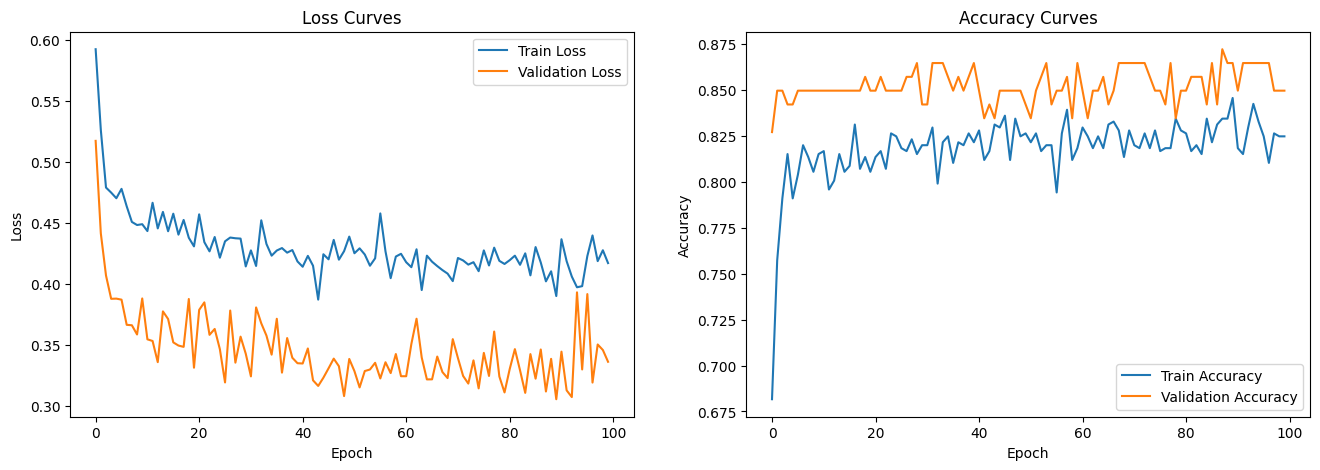

Train Loss: 0.4172
Validation Loss: 0.3363
Train Accuracy: 0.8248
Validation Accuracy: 0.8496


In [8]:
### --------------------------------------------
### TODO 1/4: modify train/validation/test split
### --------------------------------------------

train_size = 0.7
validation_size = 0.15
test_size = 0.15

# Note the inclusion of a validation set. This allows 
# for unbiased evaluation during model development,
# ensuring the test data remains unseen until final
# assessment. The validation set is used repeatedly
# during the model tuning process, whereas the test
# set provides an independent evaluation once the
# model is finalized.

### --------------------------------------------END TODO 1/4

X = df.drop(columns=['survived'])
y = df['survived']

def to_torch_tensor(X: pd.DataFrame, y: pd.Series) -> torch.Tensor:
    return (torch.tensor(X.to_numpy(dtype=np.float32), dtype=torch.float32),
            torch.tensor(y.to_numpy(dtype=np.float32), dtype=torch.float32).unsqueeze(1))

X, y = to_torch_tensor(X, y)

# Split data into train, validation, and test sets
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=validation_size/(test_size+validation_size), random_state=0, stratify=y_test)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

# (optional) Standardize the data (using the training mean and std)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_val = torch.tensor(scaler.transform(X_val), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

class TitanicNN(nn.Module):
    def __init__(self):
        super(TitanicNN, self).__init__()
        ### ------------------------------------------------
        ### TODO 2/4: Define model architecture here
        ### ------------------------------------------------
        # Linear / Fully-Connected Layer:
        self.fc1 = nn.Linear(in_features=X.shape[1], out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=1)
        # Regularization Techniques:
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.2)
        
        #For Batch Normalization
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        # Activation Functions:
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        #...
        ### ------------------------------------------------END TODO 2/4
    
    def forward(self, x):
        ### ------------------------------------------------
        ### TODO 3/4: Define forward pass here
        ### ------------------------------------------------
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Second layer 
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Third layer 
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer with sigmoid activation 
        x = self.fc4(x)
        x = self.sigmoid(x)
    
        return x
        ### ------------------------------------------------END TODO 3/4

# Alternative method of defining your model:
# model = nn.Sequential(
#     nn.Linear(in_features=X.shape[1], out_features=1),
#     ...,
#     )

model = TitanicNN()

### ---------------------------------------------------------------------------
### TODO 4/4: modify hyperparameters (choice of optimizer, learning rate, etc.)
### ---------------------------------------------------------------------------

# Epochs: the number of complete passes of the training dataset
epochs = 100

# Batch Size: the number of training samples
# in one forward/backward pass. Smaller batch size
# may result in more noise when calculating errors,
# while larger batch sizes obtain a more accurate
# estimate of the true gradient at the cost of
# computation time
batch_size = 16

# Learning Rate: determines step size at each
# iteration of optimizer
lr = 0.001

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4, amsgrad=False)#changed learning rate here

### ---------------------------------------------------------------------------END TODO 4/4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0], shuffle=True)

def train_validate(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, loss_function: nn.Module, optimizer: torch.optim.Optimizer):
    """
    Runs a single epoch of training and validation for a given model.

    This function trains the model for one epoch using the provided training data, 
    computes the loss, performs backpropagation, and updates the model's parameters. 
    It also evaluates the model on the validation set and returns the average training 
    and validation losses and accuracies for the epoch.

    Args:
        train_loader: DataLoader for the training dataset. 
            Contains batches of input data and corresponding labels.
        val_loader: DataLoader for the validation dataset. 
            Contains batches of input data and corresponding labels.
        model: The neural network model to be trained and validated.
        loss_function: Loss function to be used for computing the loss. 
            For example, `torch.nn.CrossEntropyLoss` or `torch.nn.BCELoss`.
        optimizer: Optimizer for updating the model's parameters 
            based on the computed gradients. For example, `torch.optim.Adam` or `torch.optim.SGD`.

    Returns:
        tuple: A tuple containing:
            - train_loss (float): The average loss over the training dataset for this epoch.
            - val_loss (float): The average loss over the validation dataset for this epoch.
            - train_accuracy (float): The accuracy over the training dataset for this epoch.
            - val_accuracy (float): The accuracy over the validation dataset for this epoch.

    """
    size = len(train_loader.dataset)
    model.train()
    running_loss, train_accuracy = 0, 0
    for batch, (X, y) in enumerate(train_loader):

        # Compute prediction error
        pred = model(X)
        loss = loss_function(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        # Convert probabilities to binary predictions
        pred_binary = (pred > 0.5).float()
        correct_predictions = (pred_binary.squeeze(1) == y.squeeze(1)).float().sum().item()
        train_accuracy += correct_predictions
    
    train_loss = running_loss / len(train_loader)
    train_accuracy /= size

    size = len(val_loader.dataset)
    num_batches = len(val_loader)
    model.eval()
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            pred = model(X)
            val_loss += loss_function(pred, y).item()

            # Convert probabilities to binary predictions
            pred_binary = (pred > 0.5).float()
            correct_predictions = (pred_binary.squeeze(1) == y.squeeze(1)).float().sum().item()
            val_accuracy += correct_predictions

    val_loss /= num_batches
    val_accuracy /= size
    return train_loss, val_loss, train_accuracy, val_accuracy

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for t in range(epochs):
    train_loss, val_loss, train_accuracy, val_accuracy = train_validate(train_loader, val_loader, model, loss_function, optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

def plot_train_curves(train_losses: list[float], val_losses: list[float], train_accuracies: list[float], val_accuracies: list[float]) -> None:
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.show()

    print(f'Train Loss: {train_losses[-1]:.4f}')
    print(f'Validation Loss: {val_losses[-1]:.4f}')
    print(f'Train Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

plot_train_curves(train_losses, val_losses, train_accuracies, val_accuracies)


# Model Testing

After training and optimizing your model, run the below cell to test it on your test dataset. The test function have already been written for you

In [9]:
def test(test_loader, model, loss_function):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    model.eval()
    test_loss, correct_predictions = 0, 0
    
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            test_loss += loss_function(pred, y).item()

            # Convert probabilities to binary predictions
            pred_binary = (pred > 0.5).float()
            correct_predictions += (pred_binary.squeeze(1) == y.squeeze(1)).float().sum().item()
    
    # Average loss and accuracy
    test_loss /= num_batches
    test_accuracy = correct_predictions / size * 100  # Convert to percentage

    print(f"Test Set Metrics:\n Accuracy: {test_accuracy:>0.1f}%\n Loss: {test_loss:>8f} \n")
    
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0], shuffle=True)
test(test_loader, model, loss_function)

Test Set Metrics:
 Accuracy: 85.8%
 Loss: 0.365789 

